# Titanic - quick example
## Wo will die?

### load python modules

In [292]:
import pandas as pd
import argparse
import mlflow
import scipy

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns

from sklearn_pandas import DataFrameMapper
from sklearn_pandas import FunctionTransformer
import mlflow
import mlflow.sklearn

### load raw data

In [140]:
titanic = pd.read_csv('../data/data/titanic_new.csv')

In [141]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [142]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [143]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Feature Engineering Functions
1. title
2. deck number
3. family size

### 1. extract title

In [144]:
# solution
# idx 796 (Dr.)
titanic['Name'].iloc[796]

'Leader, Dr. Alice (Farnham)'

In [145]:
# just execute
import re
def getTitle(name):
    'Extracts the word on front of a dot (.)'
    title = re.search(r'(\w+\.)',name)
    return title.group(1)

In [146]:
getTitle(titanic['Name'].iloc[796])

'Dr.'

In [147]:
titanic['Title'] = titanic['Name'].apply(getTitle)

In [148]:
titanic['Title'].value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Col.           2
Mlle.          2
Major.         2
Countess.      1
Don.           1
Capt.          1
Jonkheer.      1
Ms.            1
Lady.          1
Mme.           1
Sir.           1
Name: Title, dtype: int64

In [149]:
# just execute
map_dict = {
    'Ms.': 'noTitle',
    'Mlle.': 'noTitle',
    'Mr.' : 'noTitle',
    'Mrs.': 'noTitle',
    'Miss.': 'noTitle'
}

titanic['Title'] = titanic['Title'].map(map_dict).fillna('rareTitle')

In [150]:
titanic['Title'].value_counts()

noTitle      827
rareTitle     64
Name: Title, dtype: int64

### 2. Deck

In [151]:
titanic['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [152]:
# cabin list
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'unknown']

# extract function
def charInString(charlist, text):
    for element in charlist:
        if element in text:
            return element
    return 'NaN'

In [153]:
# create feature column
titanic['Deck'] = titanic['Cabin'].fillna('unknown')\
    .apply(lambda x: charInString(cabin_list, x))

In [154]:
titanic['Deck'].unique()

array(['unknown', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

### 3. Family Size

In [155]:
titanic['familySize'] = titanic['SibSp'] + titanic['Parch']

In [156]:
titanic['familySize'].describe()

count    891.000000
mean       0.904602
std        1.613459
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       10.000000
Name: familySize, dtype: float64

### Split Train Test

In [317]:
X_train, X_test, y_train, y_test = train_test_split(titanic.drop(['Survived'], axis=1), titanic['Survived'],
                                                    test_size=0.2, random_state=42)

In [318]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 331 to 102
Data columns (total 14 columns):
PassengerId    712 non-null int64
Pclass         712 non-null int64
Name           712 non-null object
Sex            712 non-null object
Age            572 non-null float64
SibSp          712 non-null int64
Parch          712 non-null int64
Ticket         712 non-null object
Fare           712 non-null float64
Cabin          159 non-null object
Embarked       710 non-null object
Title          712 non-null object
Deck           712 non-null object
familySize     712 non-null int64
dtypes: float64(2), int64(5), object(7)
memory usage: 83.4+ KB


In [319]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 709 to 10
Data columns (total 14 columns):
PassengerId    179 non-null int64
Pclass         179 non-null int64
Name           179 non-null object
Sex            179 non-null object
Age            142 non-null float64
SibSp          179 non-null int64
Parch          179 non-null int64
Ticket         179 non-null object
Fare           179 non-null float64
Cabin          45 non-null object
Embarked       179 non-null object
Title          179 non-null object
Deck           179 non-null object
familySize     179 non-null int64
dtypes: float64(2), int64(5), object(7)
memory usage: 21.0+ KB


### Model Pipe

In [320]:
def setup_model(clf, scaler=True):
    if scaler:
        mapper = DataFrameMapper([
            (['Sex'], OneHotEncoder(sparse=False, categories='auto')),
            (['Pclass'], OneHotEncoder(sparse=False, categories='auto')),
            (['Title'], OneHotEncoder(sparse=False, categories='auto')),
            (['Deck'], OneHotEncoder(sparse=False, categories='auto')),
            (['Age'], [SimpleImputer(strategy='median'), MinMaxScaler()]),
            (['Fare'], [SimpleImputer(strategy='median'), MinMaxScaler()]),
            (['familySize'], [SimpleImputer(strategy='median'), MinMaxScaler()]),
        ], df_out=True, input_df=True)
    else:
        mapper = DataFrameMapper([
            (['Sex'], OneHotEncoder(sparse=False, categories='auto')),
            (['Pclass'], OneHotEncoder(sparse=False, categories='auto')),
            (['Title'], OneHotEncoder(sparse=False, categories='auto')),
            (['Deck'], OneHotEncoder(sparse=False, categories='auto')),
            (['Age'], [SimpleImputer(strategy='median')]),
            (['Fare'], [SimpleImputer(strategy='median')]),
            (['familySize'], [SimpleImputer(strategy='median')]),
        ], df_out=True, input_df=True)

    pipe = Pipeline([
        ('prep', mapper),
        ('model', clf)
    ])

    return pipe, mapper

In [321]:
knn_clf, mapper = setup_model(KNeighborsClassifier())

In [322]:
df_transformed = mapper.fit_transform(X_train, y_train)
df_transformed.head()

,Sex_x0_female,Sex_x0_male,Pclass_x0_1,Pclass_x0_2,Pclass_x0_3,Title_x0_noTitle,Title_x0_rareTitle,Deck_x0_A,Deck_x0_B,Deck_x0_C,Deck_x0_D,Deck_x0_E,Deck_x0_F,Deck_x0_G,Deck_x0_T,Deck_x0_unknown,Age,Fare,familySize
331,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.566474,0.055628,0.0
733,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.283740,0.025374,0.0
382,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.396833,0.015469,0.0
704,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.321438,0.015330,0.1
813,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.070118,0.061045,0.6


In [323]:
X_cols = df_transformed.columns.tolist()

#### 1. knn

In [324]:
knn_clf, _ = setup_model(KNeighborsClassifier())

In [325]:
knn_clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('prep', DataFrameMapper(default=False, df_out=True,
        features=[(['Sex'], OneHotEncoder(categorical_features=None, categories='auto',
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=False)), (['Pclass'], OneHotEncoder(categorical_features=None...ki',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))])

In [326]:
y_pred = knn_clf.predict(X_test)

In [327]:
y_pred

array([1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1])

In [328]:
# correct / all
accuracy_score(y_test, y_pred)

0.8100558659217877

In [329]:
# best k (naive way without cross validation)
for element in range(1,15):
    knn_clf, _ = setup_model(KNeighborsClassifier(n_neighbors=element))
    knn_clf.fit(X_train, y_train)
    score = knn_clf.score(X_test, y_test)
    print("score(k={}) = {}".format(element, score))

score(k=1) = 0.7653631284916201
score(k=2) = 0.8212290502793296
score(k=3) = 0.7988826815642458
score(k=4) = 0.8156424581005587
score(k=5) = 0.8100558659217877
score(k=6) = 0.8379888268156425
score(k=7) = 0.8324022346368715
score(k=8) = 0.8212290502793296
score(k=9) = 0.8324022346368715
score(k=10) = 0.8100558659217877
score(k=11) = 0.8324022346368715
score(k=12) = 0.7988826815642458
score(k=13) = 0.8044692737430168
score(k=14) = 0.7932960893854749


### 2. Decision Tree

In [330]:
tree_clf_5, _ = setup_model(clf=DecisionTreeClassifier(max_depth=5), scaler=False)
tree_clf, _ = setup_model(clf=DecisionTreeClassifier(),scaler=False)

In [331]:
tree_clf.fit(X_train, y_train)
tree_clf_5.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('prep', DataFrameMapper(default=False, df_out=True,
        features=[(['Sex'], OneHotEncoder(categorical_features=None, categories='auto',
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=False)), (['Pclass'], OneHotEncoder(categorical_features=None...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

In [332]:
print("test scores")
print(tree_clf_5.score(X_test, y_test))
print(tree_clf.score(X_test, y_test))

print("train scores")
print(tree_clf_5.score(X_train, y_train))
print(tree_clf.score(X_train, y_train)) 

test scores
0.8044692737430168
0.7541899441340782
train scores
0.8595505617977528
0.9845505617977528


In [333]:
tree = tree_clf.named_steps['model']
tree_5 = tree_clf_5.named_steps['model']

In [334]:
export_graphviz(tree, out_file="tree.dot",
                feature_names=X_cols,
                filled=True, rounded=True)

export_graphviz(tree_5, out_file="tree_5.dot",
                feature_names=X_cols,
                filled=True, rounded=True)

In [335]:
%%bash
dot -Tpng tree.dot -o tree_clf.png
dot -Tpng tree_5.dot -o tree_clf_5.png

## 3. Random Forest

In [348]:
rf_clf,_ = setup_model(RandomForestClassifier(n_estimators=100, max_depth=10), scaler=False)

In [349]:
rf_clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('prep', DataFrameMapper(default=False, df_out=True,
        features=[(['Sex'], OneHotEncoder(categorical_features=None, categories='auto',
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=False)), (['Pclass'], OneHotEncoder(categorical_features=None...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [350]:
rf_clf.score(X_test, y_test)

0.8324022346368715

In [351]:
y_pred = rf_clf.predict(X_test)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f252f95e5c0>)

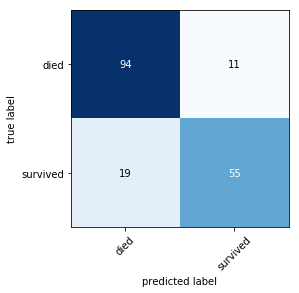

In [352]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, class_names=['died', 'survived'])

### Feature Importance

In [353]:
rf = rf_clf.named_steps['model']

In [354]:
importance = pd.Series(rf.feature_importances_, index=X_cols)
importance.index = [element.split('_')[0] for element in importance.index]
importance.groupby(importance.index).sum().sort_values(ascending=False)

Sex           0.342899
Fare          0.197309
Age           0.173366
Pclass        0.101685
familySize    0.080680
Deck          0.080379
Title         0.023682
dtype: float64

### probabilities

In [355]:
y_proba = rf_clf.predict_proba(X_test)[:,1]

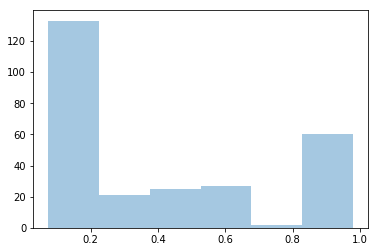

In [356]:
sns.distplot(proba, kde=False)

In [357]:
# Just execute

from matplotlib import pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds,
                                      color="g", labels=('Precision', 'Recall')):
    '''Function takes precisions, recalls and
    thresholds as arguments and generates a plot with two curves.
        Optionally you can define the color and the labels.'''
    fig = plt.figure()
    plt.plot(thresholds, precisions[:-1], color + "--", label = labels[0])
    plt.plot(thresholds, recalls[:-1], color + "-", label = labels[1])
    plt.xlabel("Threshold")
    plt.legend(loc="lower left")
    return fig

def plot_precision_vs_recall(precisions, recalls, color="g", label='model'):
    fig = plt.figure()
    plt.plot(recalls, precisions, color + "--", label = label)
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="upper right")
    return fig

In [358]:
# Compute precision, recall and threshold
from sklearn.metrics import precision_recall_curve
precision, recall, threshold = precision_recall_curve(y_test, y_proba)

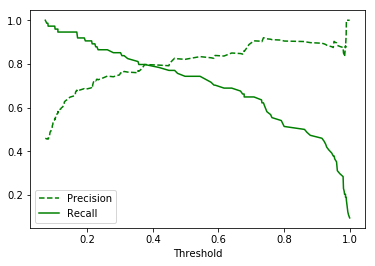

In [359]:
fig = plot_precision_recall_vs_threshold(precision, recall, threshold)